# 0. Imports

In [1]:
!pip install segmentation-models-pytorch

import segmentation_models_pytorch as smp

from google.colab.patches import cv2_imshow

from IPython.display import clear_output
from IPython import display

from google.colab import drive

from skimage.io import imread
from skimage.transform import resize

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib import rcParams

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import utils
from torchvision import models
import torch.nn.functional as F

import os

import cv2

import math

import torch

from time import time

import matplotlib.pyplot as plt

clear_output()

# 1. Data Processing

In [2]:
rcParams['figure.figsize'] = (15,4)

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/dataset.zip
clear_output()

In [5]:
images = []
masks = []
root = 'dataset'

for root, dirs, files in os.walk(os.path.join(root, 'images')):
    if root.endswith('image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('mask'):
        masks.append(imread(os.path.join(root, files[0]), 'RGB'))

images = [i[...,:3] for i in images]

size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in masks]

X = np.array(X, np.float32)
Y = np.array(Y, np.float32)

print(f'Loaded {len(X)} images')
print(f'Loaded {len(Y)} masks')

Loaded 608 images
Loaded 608 masks


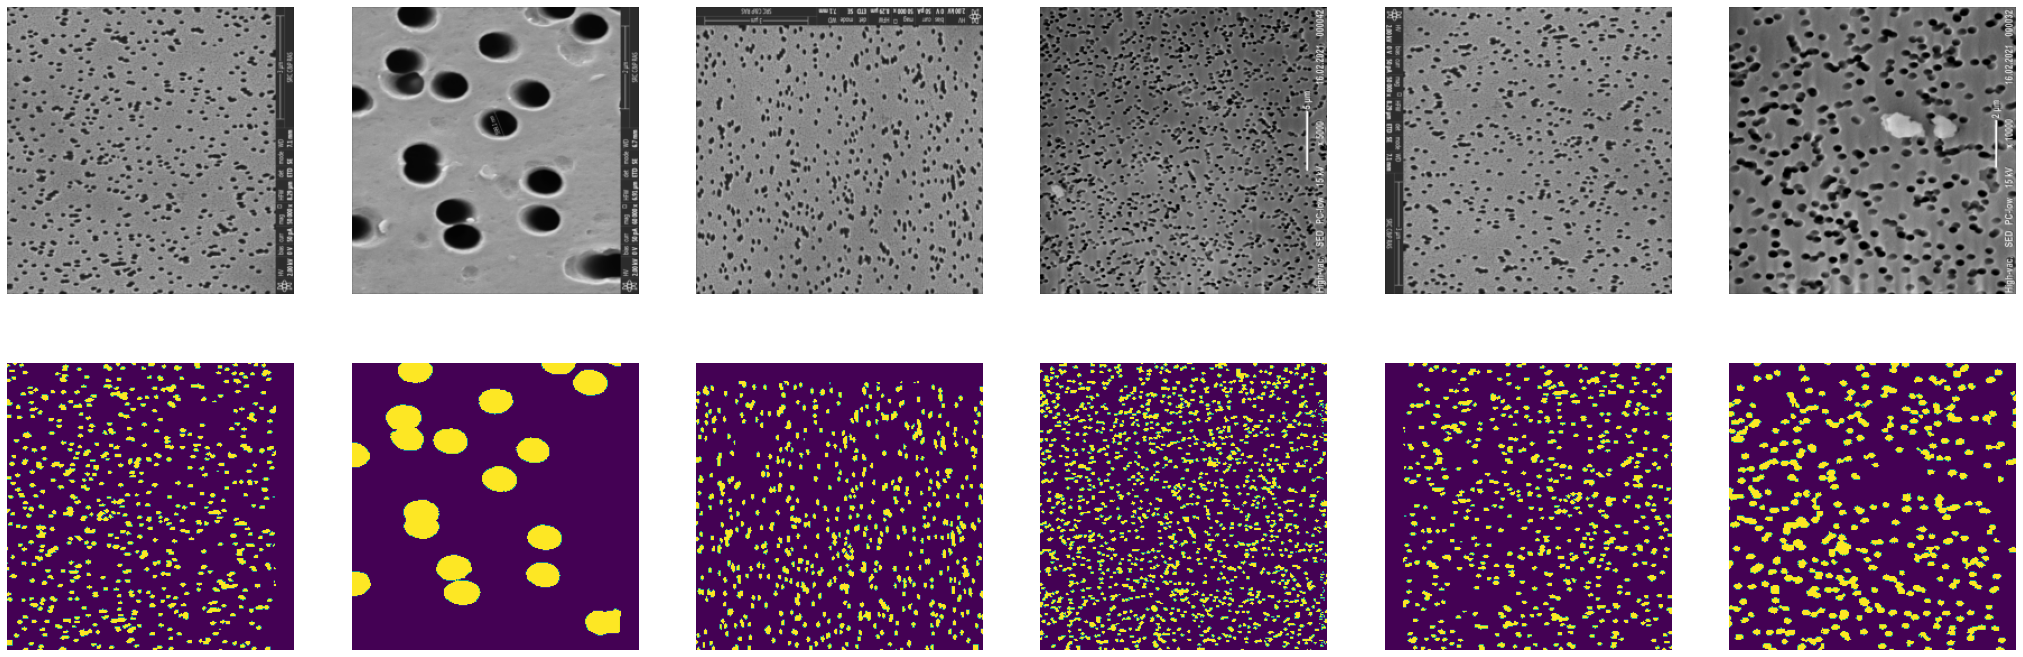

In [6]:
plt.figure(figsize=(36, 12))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

In [7]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [550, 579])
print('Training: {}   Validation: {}   Test: {}'.format(len(tr), len(val), len(ts)))

Training: 550   Validation: 29   Test: 29


In [8]:
batch_size = 25

data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Device is', device)

Device is cuda


# 2. Metrics

In [10]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()  
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  
    union = (outputs | labels).float().sum((1, 2))         
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  
    
    return thresholded  

In [11]:
def score_model(model, metric, data):
    model.eval()
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        scores += metric(Y_pred > 0, Y_label.to(device)).mean().item()
    return scores/len(data)

# 3. Models

## 3.1. UNet

In [12]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 32, kernel_size=3,stride=1,padding=1)
        self.pool0 = nn.MaxPool2d(kernel_size = 2, stride = 2)   # 256 -> 128
        self.enc_conv1 = nn.Conv2d(32, 64, kernel_size=3,stride=1,padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)  # 128 -> 64
        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=3,stride=1,padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)  # 64 -> 32
        self.enc_conv3 = nn.Conv2d(128, 256, kernel_size=3,stride=1,padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(256, 256, kernel_size=3,stride=1,padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.UpsamplingBilinear2d(scale_factor = 2)  # 16 -> 32
        self.dec_conv0 = nn.Conv2d(128+256, 128, kernel_size=3,padding=1)
        self.upsample1 = nn.UpsamplingBilinear2d(scale_factor = 2) # 32 -> 64
        self.dec_conv1 = nn.Conv2d(64+128, 64, kernel_size=3,padding=1)
        self.upsample2 = nn.UpsamplingBilinear2d(scale_factor = 2)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(32+64, 32, kernel_size=3,padding=1)
        self.upsample3 = nn.UpsamplingBilinear2d(scale_factor = 2)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(32, 1, kernel_size=3,padding=1)

    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.enc_conv0(x)))
        e1 = self.pool1(F.relu(self.enc_conv1(e0)))
        e2 = self.pool2(F.relu(self.enc_conv2(e1)))
        e3 = self.pool3(F.relu(self.enc_conv3(e2)))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        b = self.upsample0(b)
        d0 = F.relu(self.dec_conv0(torch.cat((b, e2), dim=1)))
        d0 = self.upsample1(d0)
        d1 = F.relu(self.dec_conv1(torch.cat((d0, e1), dim=1)))
        d1 = self.upsample2(d1)
        d2 = F.relu(self.dec_conv2(torch.cat((d1, e0), dim=1)))
        d2 = self.upsample3(d2)
        d3 = self.dec_conv3(d2)  # no activation
        return d3

## 3.2. UNet 512x512

In [13]:
class UNet_512(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv00 = nn.Conv2d(3, 32, kernel_size=3,stride=1,padding=1)
        self.pool00 = nn.MaxPool2d(kernel_size = 2, stride = 2)   # 512 -> 256
        self.enc_conv0 = nn.Conv2d(32, 64, kernel_size=3,stride=1,padding=1)
        self.pool0 = nn.MaxPool2d(kernel_size = 2, stride = 2)   # 256 -> 128
        self.enc_conv1 = nn.Conv2d(64, 128, kernel_size=3,stride=1,padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)  # 128 -> 64
        self.enc_conv2 = nn.Conv2d(128, 256, kernel_size=3,stride=1,padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)  # 64 -> 32
        self.enc_conv3 = nn.Conv2d(256, 512, kernel_size=3,stride=1,padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)  # 32 -> 16
        

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(512, 512, kernel_size=3,stride=1,padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.UpsamplingBilinear2d(scale_factor = 2)  # 16 -> 32
        self.dec_conv0 = nn.Conv2d(256+512, 256, kernel_size=3,padding=1)
        self.upsample1 = nn.UpsamplingBilinear2d(scale_factor = 2) # 32 -> 64
        self.dec_conv1 = nn.Conv2d(128+256, 128, kernel_size=3,padding=1)
        self.upsample2 = nn.UpsamplingBilinear2d(scale_factor = 2)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(64+128, 64, kernel_size=3,padding=1)
        self.upsample3 = nn.UpsamplingBilinear2d(scale_factor = 2)  # 128 -> 256
        self.dec_conv22 = nn.Conv2d(32+64, 32, kernel_size=3,padding=1)
        self.upsample33 = nn.UpsamplingBilinear2d(scale_factor = 2)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(32, 1, kernel_size=3,padding=1)

    def forward(self, x):
        # encoder
        e00 = self.pool00(F.relu(self.enc_conv00(x)))
        e0 = self.pool0(F.relu(self.enc_conv0(e00)))
        e1 = self.pool1(F.relu(self.enc_conv1(e0)))
        e2 = self.pool2(F.relu(self.enc_conv2(e1)))
        e3 = self.pool3(F.relu(self.enc_conv3(e2)))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        b = self.upsample0(b)

        d0 = F.relu(self.dec_conv0(torch.cat((b, e2), dim=1)))
        d0 = self.upsample1(d0)

        d1 = F.relu(self.dec_conv1(torch.cat((d0, e1), dim=1)))
        d1 = self.upsample2(d1)

        d2 = F.relu(self.dec_conv2(torch.cat((d1, e0), dim=1)))
        d2 = self.upsample3(d2)

        d22 = F.relu(self.dec_conv22(torch.cat((d2, e00), dim=1)))
        d22 = self.upsample33(d22)

        d3 = self.dec_conv3(d22)  # no activation
        return d3

## 3.3. SegNet

In [14]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 32, kernel_size=3,stride=1,padding=1)
        self.pool0 = nn.MaxPool2d(kernel_size = 2, stride = 2)   # 256 -> 128
        self.enc_conv1 = nn.Conv2d(32, 64, kernel_size=3,stride=1,padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)  # 128 -> 64
        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=3,stride=1,padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)  # 64 -> 32
        self.enc_conv3 = nn.Conv2d(128, 256, kernel_size=3,stride=1,padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(256, 256, kernel_size=3,stride=1,padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.UpsamplingBilinear2d(scale_factor = 2)  # 16 -> 32
        self.dec_conv0 = nn.Conv2d(256, 128, kernel_size=3,padding=1)
        self.upsample1 = nn.UpsamplingBilinear2d(scale_factor = 2) # 32 -> 64
        self.dec_conv1 = nn.Conv2d(128, 64, kernel_size=3,padding=1)
        self.upsample2 = nn.UpsamplingBilinear2d(scale_factor = 2)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(64, 32, kernel_size=3,padding=1)
        self.upsample3 = nn.UpsamplingBilinear2d(scale_factor = 2)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(32, 1, kernel_size=3,padding=1)

    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.enc_conv0(x)))
        e1 = self.pool1(F.relu(self.enc_conv1(e0)))
        e2 = self.pool2(F.relu(self.enc_conv2(e1)))
        e3 = self.pool3(F.relu(self.enc_conv3(e2)))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        d0 = self.upsample0(F.relu(self.dec_conv0(b)))
        d1 = self.upsample1(F.relu(self.dec_conv1(d0)))
        d2 = self.upsample2(F.relu(self.dec_conv2(d1)))
        d3 = self.upsample3(self.dec_conv3(d2))  # no activation
        return d3

## 3.4. UNet2

In [15]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 32, kernel_size=3,stride=2,padding=1)
        self.enc_conv1 = nn.Conv2d(32, 64, kernel_size=3,stride=2,padding=1)
        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=3,stride=2,padding=1)
        self.enc_conv3 = nn.Conv2d(128, 256, kernel_size=3,stride=2,padding=1)

        # bottleneck
        self.bottleneck_conv = nn.ConvTranspose2d(256, 256, kernel_size=3,stride=2,padding=1,output_padding=1)

        # decoder (upsampling)
        self.dec_conv0 = nn.ConvTranspose2d(128+256, 128, kernel_size=3,stride=2,padding=1,output_padding=1)
        self.dec_conv1 = nn.ConvTranspose2d(64+128, 64, kernel_size=3,stride=2,padding=1,output_padding=1)
        self.dec_conv2 = nn.ConvTranspose2d(32+64, 32, kernel_size=3,stride=2,padding=1,output_padding=1)
        self.dec_conv3 = nn.Conv2d(32, 1, kernel_size=3,stride=1,padding=1)

    def forward(self, x):
        # encoder
        e0 = F.relu(self.enc_conv0(x))
        e1 = F.relu(self.enc_conv1(e0))
        e2 = F.relu(self.enc_conv2(e1))
        e3 = F.relu(self.enc_conv3(e2))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        d0 = F.relu(self.dec_conv0(torch.cat((b, e2), dim=1)))
        d1 = F.relu(self.dec_conv1(torch.cat((d0, e1), dim=1)))
        d2 = F.relu(self.dec_conv2(torch.cat((d1, e0), dim=1)))
        d3 = self.dec_conv3(d2)  # no activation
        return d3

## 3.5. Loading model

In [16]:
model = smp.UnetPlusPlus(encoder_weights=None).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# 4. Loss function

In [17]:
def bce_loss(y_real, y_pred):
  eps = 1e-10
  return (y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred) + eps)).mean()

In [18]:
def dice_loss(target, pred):
    pred = torch.sigmoid(pred)
    smooth = 1.
    iflat = pred.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()
    A_sum = torch.sum(iflat * iflat)
    B_sum = torch.sum(tflat * tflat)
    return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

In [19]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred = torch.sigmoid(y_pred)
    y_pred = y_pred.contiguous().view(y_pred.shape[0], -1)
    y_real = y_real.contiguous().view(y_real.shape[0], -1)

    pt = y_real*y_pred + (1 - y_real)*(1 - y_pred)
    res = (((1 - pt)**gamma)*torch.log(pt))
    return (-1)*res.mean()

# 5. Training

In [20]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    
    loss_plot_test = list()
    loss_plot_val = list()

    for epoch in range(epochs): 
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        avg_loss = 0
        model.train() 
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            opt.zero_grad() 
            Y_pred = model.forward(X_batch) 
            loss = loss_fn(Y_batch, Y_pred) 
            loss.backward() 
            opt.step()  
            # sch.step()
            avg_loss += loss / len(data_tr) 
        toc = time()     
        loss_plot_test.append(avg_loss)
        print('loss: %f' % avg_loss)

        avg_loss_val = 0 
        model.train() 
        for X_batch, Y_batch in data_val:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            opt.zero_grad()
            Y_pred = model.forward(X_batch) 
            loss = loss_fn(Y_batch, Y_pred)
            loss.backward()
            opt.step()
            avg_loss_val += loss / len(data_val) 
        loss_plot_val.append(avg_loss_val)

        model.eval() 
        Y_hat = model(X_val.to(device)).detach().cpu().numpy()
        
        display.clear_output(wait=True)

        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0] > 0.5, cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
    return loss_plot_test, loss_plot_val

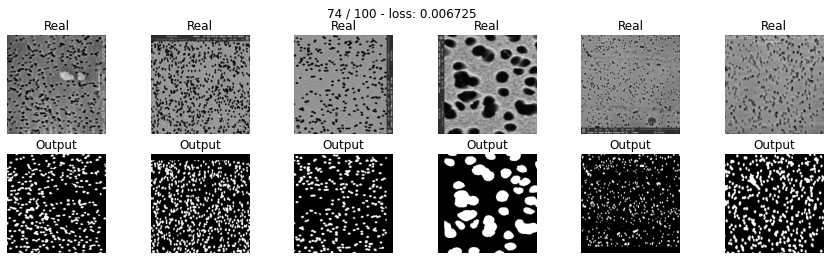

* Epoch 75/100


In [ ]:
start = time()
loss_unet_test, loss_unet_val = train(model, optimizer, bce_loss, 100, data_tr, data_val)
end = time()
time_unet = end - start

plt.figure(figsize=(15, 12))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.plot(loss_unet_test, label = 'Test')
plt.plot(loss_unet_val, label = 'Val')
plt.title('UNet', fontsize=18)
plt.grid()
plt.legend(fontsize=18)
plt.xlabel('Номер эпохи', fontsize=18)
plt.ylabel('Значение лосса', fontsize=18)

print('Time passed: {:.3} sec'.format(time_unet))

# 6. Evaluation

In [ ]:
score_unetbce_test = score_model(model, smp.utils.metrics.IoU(threshold=0.5), data_ts)
score_unetbce_val = score_model(model, smp.utils.metrics.IoU(threshold=0.5), data_val)
print('Test score: {}   Val score: {}'.format(score_unetbce_test, score_unetbce_val))

Test score: 0.9984650015830994   Val score: 0.9991796612739563


In [ ]:
IoU = smp.utils.metrics.IoU(threshold=0.5)

# 7. Saving model

In [ ]:
torch.save(model.state_dict(), 'model_weigth.pth')

# new_model = UNet().to(device)
# new_model.load_state_dict(torch.load('best_model1.pth'))

In [ ]:
model

UnetPlusPlus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [ ]:
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.cpu().detach().numpy().transpose((1, 2, 0)))

layer = 1
filter = model.conv1.weight.clone()
visTensor(filter, ch=0, allkernels=False)
# plt.figure(figsize=(18,18))
plt.axis('off')
plt.ioff()
plt.show()

# 8. Weights check

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Device is', device)

Device is cuda


In [ ]:
model = smp.UnetPlusPlus(encoder_weights=None).to(device)

Load weights

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/model_weigth.pth'))
model.eval()

Load image

In [ ]:
real = cv2.imread('/content/4.png')
init_width = real.shape[1]
init_height = real.shape[0]

Apply model

In [ ]:
real = [resize(real, (256, 256), mode='constant', anti_aliasing=True)]

real = np.array(real, np.float32)

data_real = DataLoader(list(zip(np.rollaxis(real, 3, 1))),
                     batch_size=25, shuffle=True)

X = next(iter(data_real))
Y_hat = model(X[0].to(device)).detach().cpu().numpy()

Y_hat_bool = Y_hat[0, 0] > 0.5

Y_hat_bool = cv2.resize(np.float32(Y_hat_bool), (init_width, init_height), interpolation = cv2.INTER_AREA)

Show image

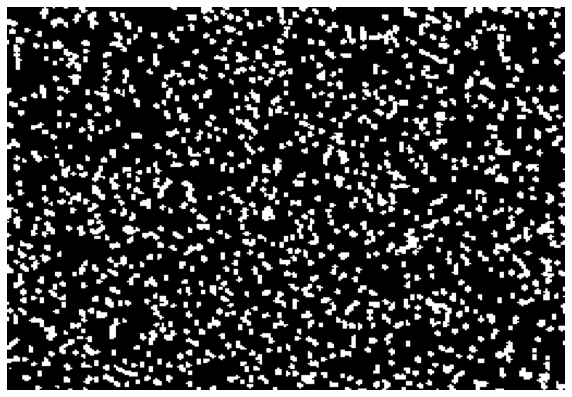

In [ ]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(Y_hat_bool, cmap='gray')

Save image

In [ ]:
if cv2.imwrite('real_mask.png', Y_hat_bool*255):
  print('Image saved!')

Image saved!


Calculate porosity

In [ ]:
WH = init_width * init_height
non_zero = np.count_nonzero(Y_hat_bool)
porosity = non_zero/WH*100
print('Porosity [%] = {:.5f}'.format(porosity))

Porosity [%] = 19.66472


Pores localization

In [ ]:
coordinates = []

img = cv2.imread('/content/real_mask.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

ret, bin_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)

out_img = img.copy()
contours, hierarchy = cv2.findContours(bin_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

Медиана = 153.0


Text(600, 1450, 'Медиана = 153.0')

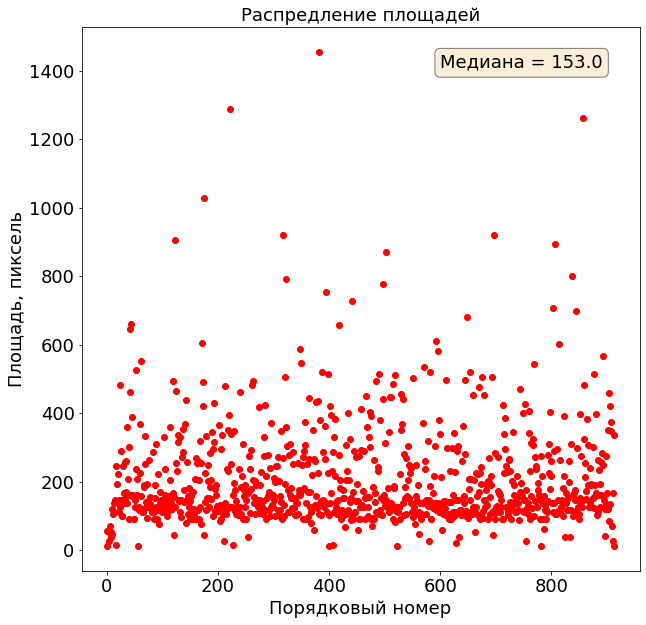

In [ ]:
area = []

for i in range(len(contours)):
    area.append(cv2.contourArea(contours[i]))

plt.figure(figsize=(10,10))
plt.title('Распредление площадей', fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel('Площадь, пиксель', fontsize=18)
plt.xlabel('Порядковый номер', fontsize=18)
plt.scatter(range(len(area)), area, color='red')

md = np.median(area) #max(set(area), key=area.count)
print('Медиана =',md)

textstr = 'Медиана = {}'.format(md)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(600, 1450, textstr, fontsize=18, verticalalignment='top', bbox=props)

Image saved!


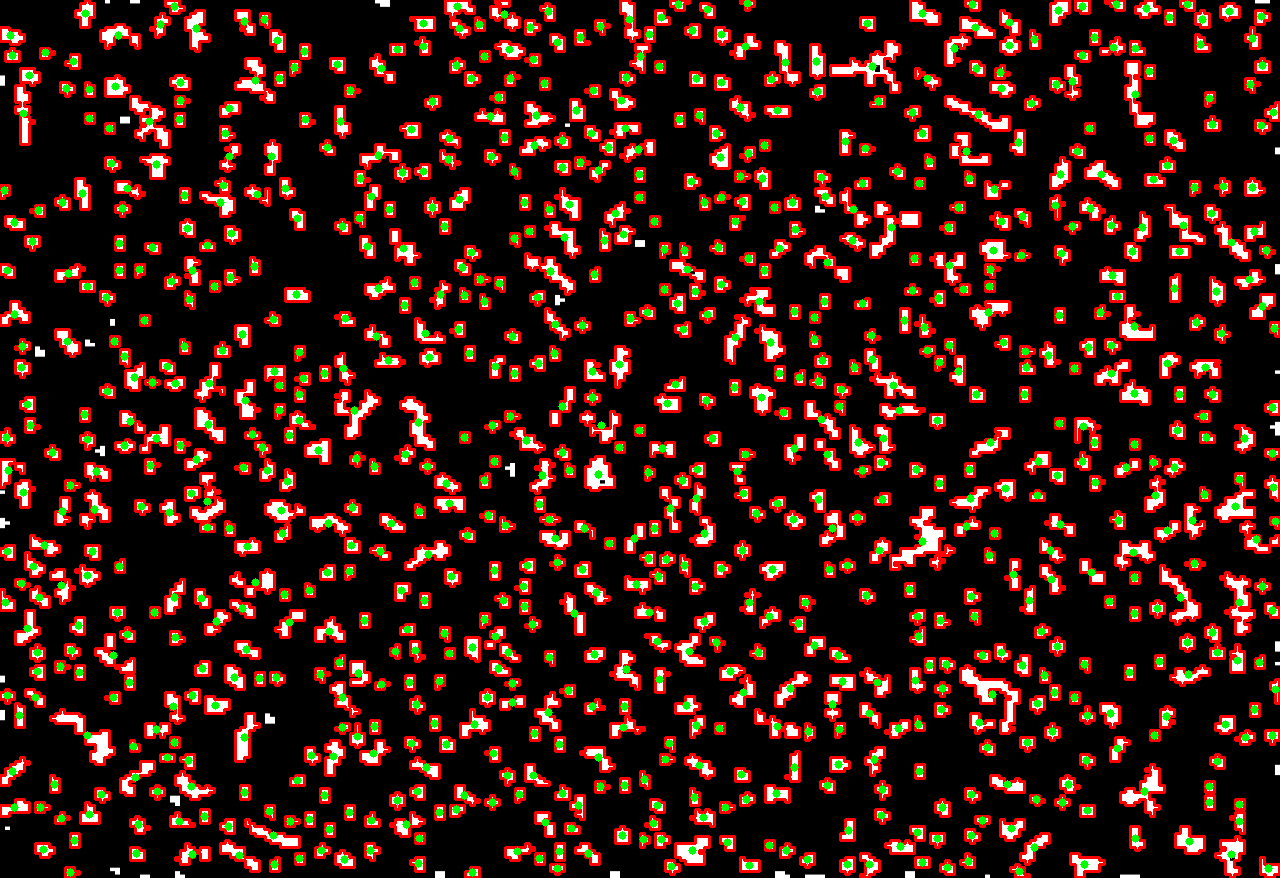

In [ ]:
for i in range(len(contours)):
    if cv2.contourArea(contours[i]) > md/2:
      M = cv2.moments(contours[i])
      if(M['m00'] == 0.0):
          continue
      x, y = int(M['m10'] / M['m00']), int(M['m01'] / M['m00'])

      coordinates.append([x, y])

      out_img = cv2.drawContours(out_img, contours, i, (0,0,255), 2)
      cv2.circle(out_img, (x, y), 4, (0,255,0), -1)

if cv2.imwrite('pores_localization.png', out_img):
  print('Image saved!')

cv2_imshow(out_img)

Number of pores: 1267
Overlap % ratio = 21.231
Image saved!


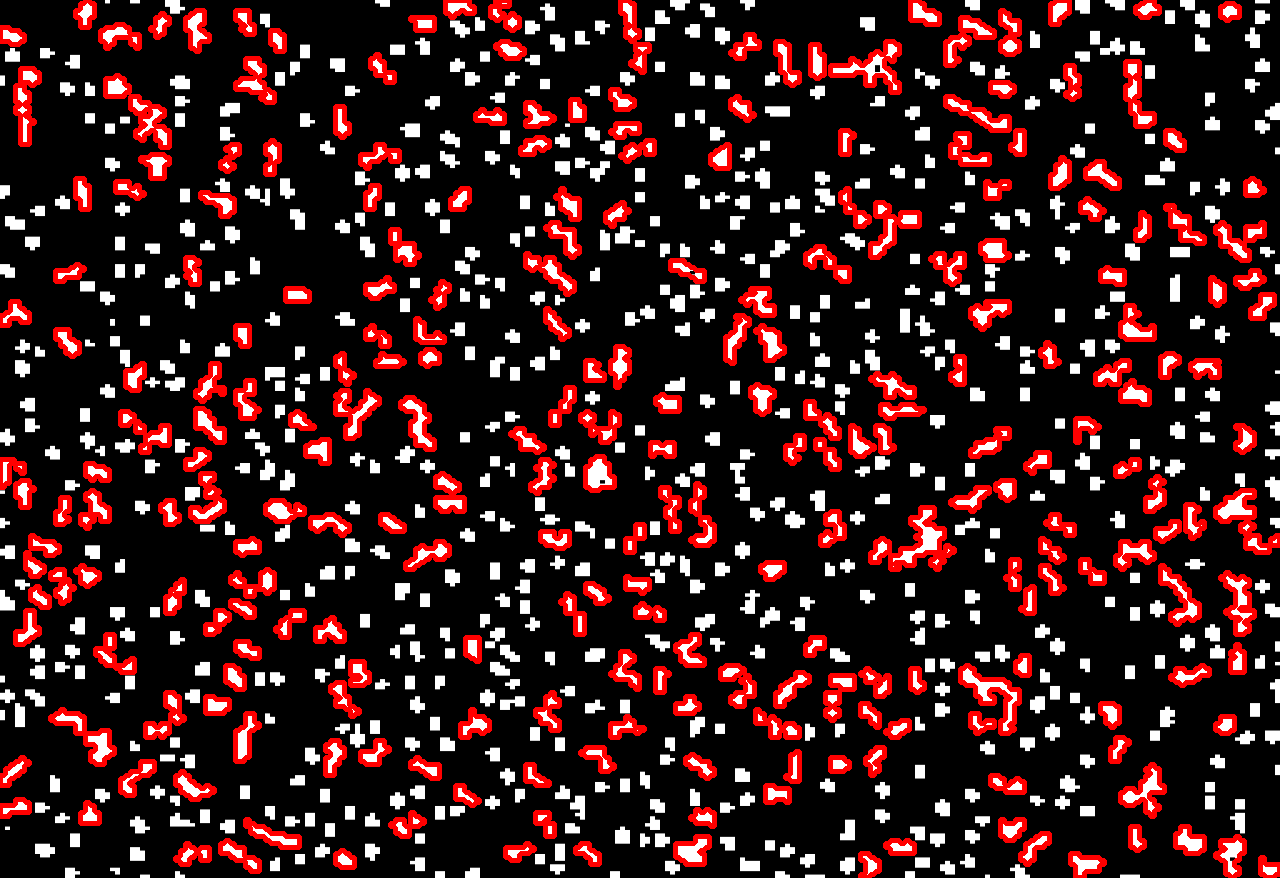

In [ ]:
image = img.copy()

single_area = 3*md/2
pores = len(contours)
overlapping = 0

for c in contours:
    area = cv2.contourArea(c)
    cntr_area = math.ceil(area/single_area)
    if cntr_area > 1:
        pores += cntr_area - 1
        overlapping += 1
        cv2.drawContours(image, [c], -1, (0,0,255), 3)

print('Number of pores:', pores)
print('Overlap % ratio = {:.3f}'.format(overlapping/pores*100))

if cv2.imwrite('overlap_localization.png', image):
  print('Image saved!')

cv2_imshow(image)

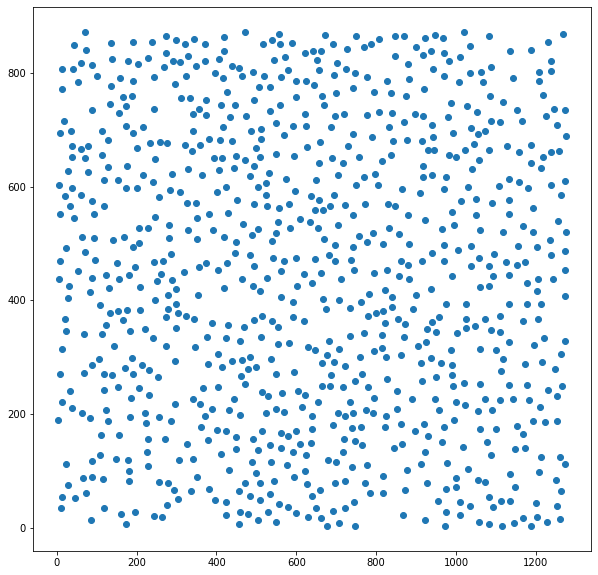

In [ ]:
x, y = [], []
for xy in coordinates:
  x.append(xy[0])
  y.append(xy[1])

plt.figure(figsize=(10,10))
plt.scatter(x, y)

In [ ]:
distances = []

for xy in coordinates:
  d_min = np.inf
  d = 0
  x_min, y_min = 0, 0
  x0, y0 = xy[0], xy[1]
  for xy_ in coordinates:
    x1, y1 = xy_[0], xy_[1]
    d = np.sqrt((x0-x1)**2+(y0-y1)**2)
    if d < d_min and (x0 != x1) and (y0 != y1):
      d_min = d
      x_min, y_min = x1, y1
  distances.append([xy, [x_min,y_min], d_min])

In [ ]:
for item in distances:
  print('Init: {}   End: {}   Distance: {:.3f}'.format(item[0], item[1], item[2]))

Init: [472, 872]   End: [517, 851]   Distance: 49.659
Init: [70, 872]   End: [74, 840]   Distance: 32.249
Init: [1019, 871]   End: [1034, 847]   Distance: 28.302
Init: [557, 868]   End: [559, 851]   Distance: 17.117
Init: [947, 867]   End: [968, 861]   Distance: 21.840
Init: [671, 866]   End: [692, 850]   Distance: 26.401
Init: [1268, 868]   End: [1231, 854]   Distance: 39.560
Init: [922, 862]   End: [947, 867]   Distance: 25.495
Init: [847, 864]   End: [848, 830]   Distance: 34.015
Init: [749, 865]   End: [769, 845]   Distance: 28.284
Init: [418, 863]   End: [419, 838]   Distance: 25.020
Init: [274, 864]   End: [299, 858]   Distance: 25.710
Init: [1084, 864]   End: [1034, 847]   Distance: 52.811
Init: [968, 861]   End: [947, 867]   Distance: 21.840
Init: [869, 864]   End: [900, 846]   Distance: 35.847
Init: [807, 859]   End: [786, 850]   Distance: 22.847
Init: [539, 858]   End: [557, 868]   Distance: 20.591
Init: [299, 858]   End: [321, 850]   Distance: 23.409
Init: [344, 859]   End: 

(array([ 72., 235., 256., 155.,  79.,  48.,  13.,   6.,   5.,   2.]),
 array([14.86606875, 18.66056024, 22.45505174, 26.24954323, 30.04403473,
        33.83852623, 37.63301772, 41.42750922, 45.22200071, 49.01649221,
        52.81098371]),
 <a list of 10 Patch objects>)

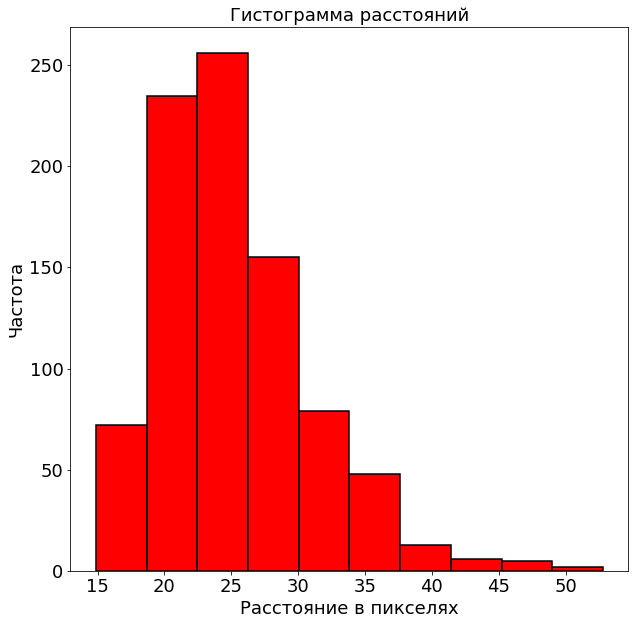

In [ ]:
dst = [i[2] for i in distances]
plt.figure(figsize=(10,10))
plt.title('Гистограмма расстояний', fontsize=18)
plt.xlabel('Расстояние в пикселях', fontsize=18)
plt.ylabel('Частота', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.hist(dst, bins=10, color='red', edgecolor='black', linewidth=1.5)

(array([ 72., 235., 256., 155.,  79.,  48.,  13.,   6.,   5.,   2.]),
 array([139.74104622, 175.40926629, 211.07748635, 246.74570641,
        282.41392647, 318.08214653, 353.75036659, 389.41858665,
        425.08680671, 460.75502678, 496.42324684]),
 <a list of 10 Patch objects>)

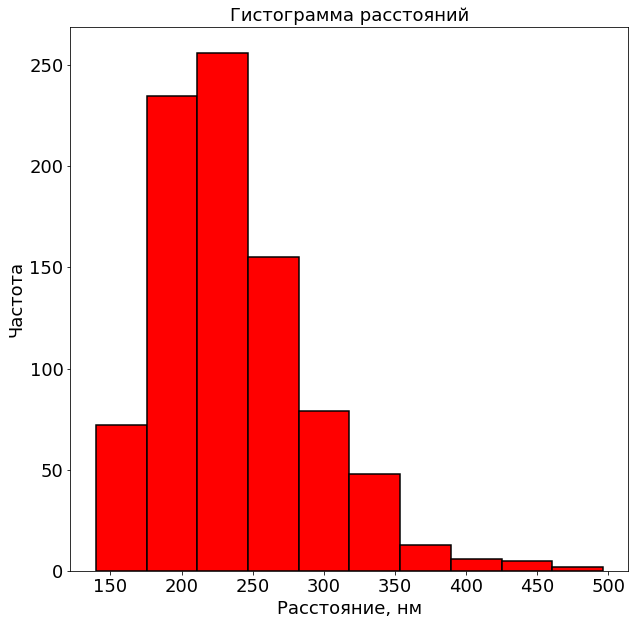

In [ ]:
dst = [i[2]*9.4 for i in distances]
plt.figure(figsize=(10,10))
plt.title('Гистограмма расстояний', fontsize=18)
plt.xlabel('Расстояние, нм', fontsize=18)
plt.ylabel('Частота', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.hist(dst, bins=10, color='red', edgecolor='black', linewidth=1.5)